In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, ZeroPadding2D, Activation, Add, Conv2D, Dense, Layer, Conv2DTranspose, LeakyReLU, Reshape, Flatten
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print("Number of original training examples:", len(x_train), x_train.shape)
print("Number of original test examples:", len(x_test), x_test.shape)

Number of original training examples: 60000 (60000, 28, 28, 1)
Number of original test examples: 10000 (10000, 28, 28, 1)


# Hyperparameters

In [3]:
image_shape = (28, 28, 1)
latent_dim = 32
ebm_units = 512
inf_iter = 60
inf_rate = 0.1
eta = 0.001

# EBM

In [4]:
latent_in = Input(shape=(latent_dim,))
x = Dense(ebm_units, activation=tf.nn.leaky_relu)(latent_in)
x = Dense(ebm_units//2, activation=tf.nn.leaky_relu)(x)
energy_vals = Dense(1)(x)
ebm = Model(latent_in, energy_vals, name="EBM")
ebm.trainable = False
ebm.load_weights('/users/apokkunu/trial/mnist/ebmout_18/ebm_final_500.h5')
ebm.summary()

Model: "EBM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 512)               16896     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 148,481
Trainable params: 0
Non-trainable params: 148,481
_________________________________________________________________


# Inference Functions

In [5]:
def compute_gradient(z):
    with tf.GradientTape() as tape:
        tape.watch(z)
        energy = ebm(z) + 0.5 * tf.reduce_sum(tf.pow(z,2), axis=1)
    return tape.gradient(energy, z), energy

def langevin_inf(z, orig_z, inf_iter, inf_rate, eta, mode, step, epoch):
    current_z = z
    
    if mode == 'val':
        z_arr = [current_z]
        
    for i in range(inf_iter):
        gradients, energy = compute_gradient(current_z)
        
        # Langevin dynamics
        term1 = 0.5 * inf_rate * gradients
        term2 = eta * tf.random.normal(current_z.get_shape().as_list())
        next_z = current_z - term1 + term2
        current_z = next_z
        
        if step % 50 == 0 and epoch % 10 == 0 and mode == 'train':
            template = "LD Step: {}, Avg. MSE: {}, Avg. energy: {}"
            mse = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.mean_squared_error(model_decoder(orig_z), model_decoder(current_z)), axis=(1, 2))).numpy()
            print(template.format(i, mse, tf.reduce_mean(energy).numpy()), flush=True)
        
        if mode == 'val':
            z_arr.append(current_z)
    
    if mode == 'train':
        return current_z
    else:
        return current_z, np.array(z_arr)

def predict_inf(model_de, z, orig_z, orig_img, inf_iter, inf_rate, eta):
    mode = 'val'
    z_t, z_rr = langevin_inf(z, orig_z, inf_iter, inf_rate, eta, mode, 0, 0)
    reconstruction = model_de.predict(z_t)
    img_arr = [model_de.predict(z_rr[i]) for i in range(len(z_rr))]
    return reconstruction, np.array(img_arr)

def predict_direct(model_en, model_de, data):
    z_mean, z_var, z = model_en(data)
    reconstruction = model_de.predict(z)
    return reconstruction

def softmax(inputs):
    exp_inputs = tf.math.exp(inputs - tf.reduce_max(inputs))
    return exp_inputs / tf.reduce_sum(exp_inputs)

# Visualization

In [19]:
def make_gallery(data, ncols):
    nindex, height, width, intensity = data.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    arr = (data.reshape(nrows, ncols, height, width, intensity)).swapaxes(1,2)
    img_gallery = arr.reshape(height*nrows, width*ncols, intensity)
    plt.figure(figsize=(ncols, ncols))
    plt.imshow(img_gallery, cmap=plt.cm.gray)
    plt.xticks([]); plt.yticks([])
    plt.show()
    
def make_img(data, ncols):
    data = data[:, 0, :, :, :]
    data0 = tf.expand_dims(data[0], axis=0).numpy()
    make_gallery(data0, 1)
    make_gallery(data[1:], ncols)

def make_gallery2(model_en, model_de, mode, inf_iter, inf_rate, eta, ncols=10, num_imgs=100):
    print('original images')
    make_gallery(x_test[:num_imgs], ncols)
    
    if mode == 'LD':
        zm, zvar, orig_z = model_en(x_test[:num_imgs])
        z = tf.random.normal([num_imgs, latent_dim])
        array, ld_images = predict_inf(model_de, z, orig_z, x_test[:num_imgs], inf_iter, inf_rate, eta)
        print(array.shape, 'ld')
        
        print('\nStep wise LD Output')
        make_img(ld_images, ncols)
        
    elif mode == 'direct':
        # predict using test data
        array = predict_direct(model_en, model_de, x_test[:num_imgs ])
        print(array.shape, 'dir')
        
    elif mode == 'residual':
        arr = []
        for i in range(num_imgs):
            z = tf.random.normal([num_imgs, latent_dim])
            e_vals = ebm(z)
            probs = tf.squeeze(softmax(-e_vals))
            top_probs, top_idxs = tf.math.top_k(probs, k=1)
            top_z = z.numpy()[top_idxs.numpy()]
            arr.append(model_de.predict(top_z))
        array = np.array(arr)
        array = array[:, 0, :, :, :]
        print(array.shape)
        
    else:
        # random noise predict
        z = tf.random.normal([num_imgs, latent_dim])
        array = model_de.predict(z)
        print(array.shape, 'rand')
    
    make_gallery(array, ncols)

# VAE

In [7]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal([batch, dim])
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def conv_block(x, channels, kernel_size = 3, padding = 'same'):
    x = Conv2D(channels, kernel_size, padding=padding, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(x)
    x = LeakyReLU()(x)
    return x

def res_block(x, channels, kernel_size = 3):
    input_x = x
    x = conv_block(x, channels, kernel_size = kernel_size)
    x = Conv2D(channels, kernel_size, padding='same', use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(x)
    x = Add()([input_x, x])
    return x

def downsampling_conv_block(x, channels, kernel_size = 4):
    x = ZeroPadding2D()(x)
    x = Conv2D(channels, kernel_size, strides=(2, 2), use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(x)
    x = LeakyReLU()(x)
    return x

def upsampling_conv_block(x, channels, kernel_size = 3):
    x = Conv2DTranspose(channels, kernel_size, strides=2, padding="same")(x)
    x = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(x)
    x = LeakyReLU()(x)
    return x

def create_encoder(latent_dim, num_layer):
    encoder_iput = Input(shape=image_shape, name='image')
    channels = 32
    x = conv_block(encoder_iput, channels, kernel_size = 4)
    
    print(K.int_shape(x))
    for i in range(num_layer):
        channels *= 2
        x = downsampling_conv_block(x, channels)
        print(K.int_shape(x))
        x = res_block(x, channels)
        
    last_conv_shape = K.int_shape(x)
    x = Flatten()(x)
    
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    
    model = Model(encoder_iput, [z_mean, z_log_var, z], name='encoder', trainable=False)
    model.trainable = False
    model.load_weights('/users/apokkunu/trial/mnist/output1/128_1_0.0003/en_im_100.h5')
    model.summary()
    return model, last_conv_shape

num_layer = 2
encoder, last_conv_shape = create_encoder(latent_dim, num_layer)

# In[]:

def create_decoder(latent_dim, first_conv_shape, num_layer):
    decoder_input = Input(shape=(latent_dim,), name='latent_z')
    x = Dense(first_conv_shape[1] * first_conv_shape[2] * first_conv_shape[3])(decoder_input)
    x = Reshape((first_conv_shape[1], first_conv_shape[2], first_conv_shape[3]))(x)
    
    print(K.int_shape(x))
    channels = first_conv_shape[3]
    
    for i in range(num_layer):
        x = res_block(x, channels)
        channels //= 2
        x = upsampling_conv_block(x, channels)
        print(K.int_shape(x))
    
    x = Conv2D(1, 3, padding='same', use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(x)
    x = Activation('sigmoid', name='rec_image')(x)
    print(K.int_shape(x))
    model = Model(decoder_input, x, name='decoder', trainable=False)
    model.trainable = False
    model.load_weights('/users/apokkunu/trial/mnist/output1/128_1_0.0003/de_im_100.h5')
    model.summary()
    return model

decoder = create_decoder(latent_dim, last_conv_shape, num_layer)

(None, 28, 28, 32)
(None, 14, 14, 64)
(None, 7, 7, 128)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   512         image[0][0]                      
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 28, 28, 32)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 28, 28, 32)   0           instance_normalization[0][0]     
____________________________________


Z from p(z)
original images


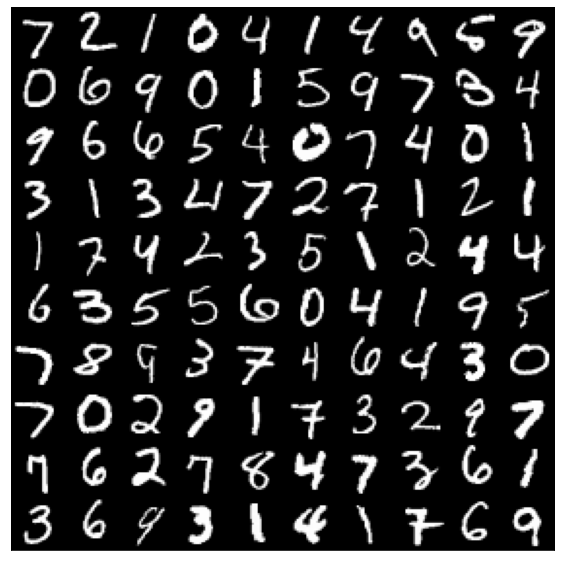

(100, 28, 28, 1) rand


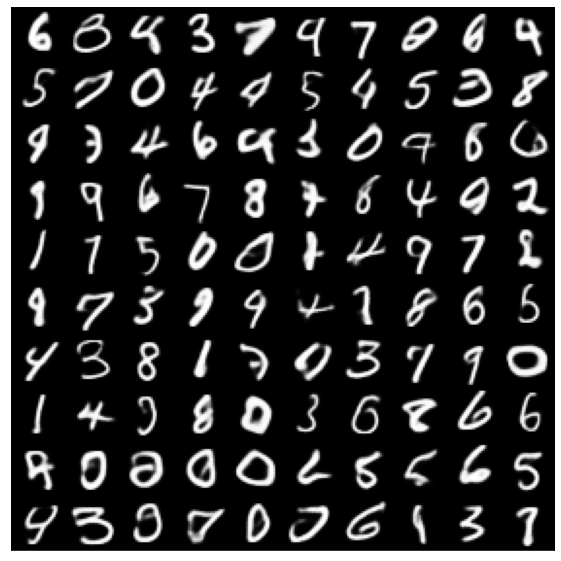

In [8]:
print('\nZ from p(z)')
make_gallery2(encoder, decoder, 'vae', inf_iter, inf_rate, eta)


Z from q(z|x)
original images


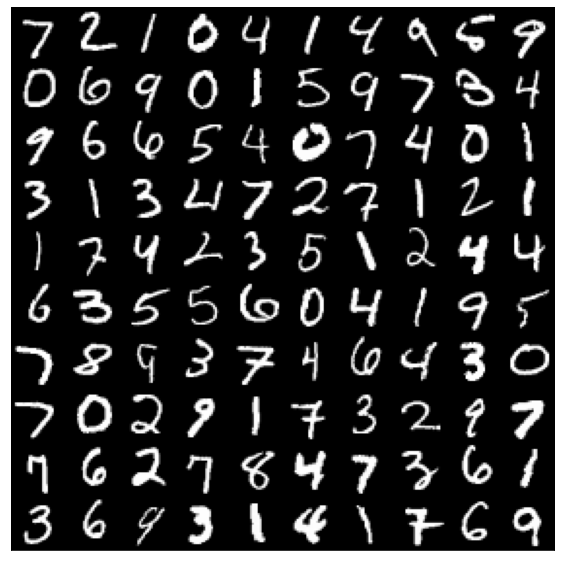

(100, 28, 28, 1) dir


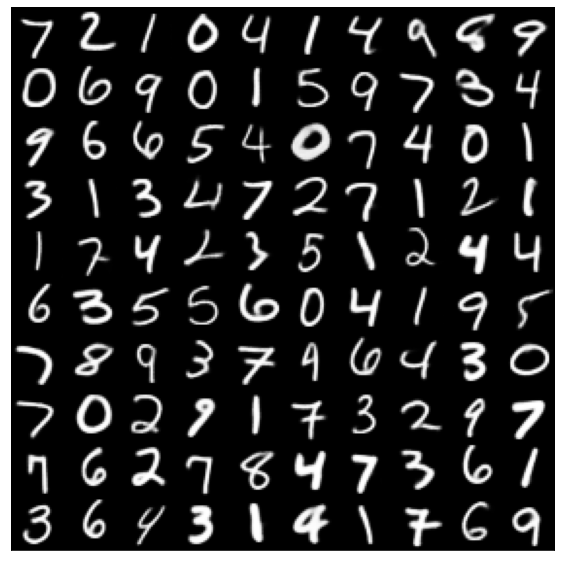

In [9]:
print('\nZ from q(z|x)')
make_gallery2(encoder, decoder, 'direct', inf_iter, inf_rate, eta)


Z from LD
original images


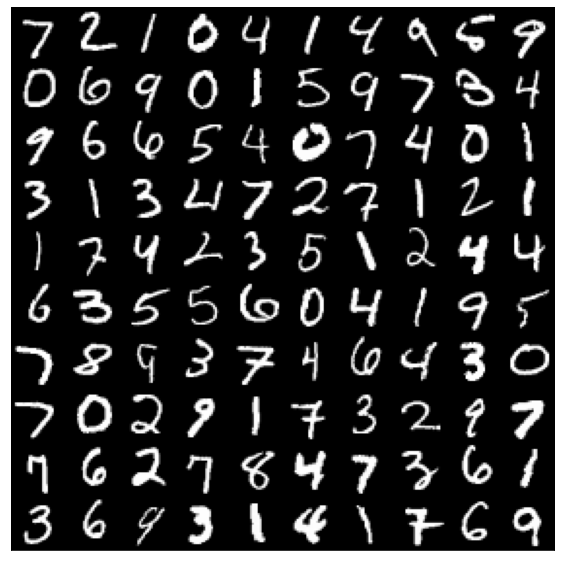

(100, 28, 28, 1) ld

Step wise LD Output


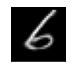

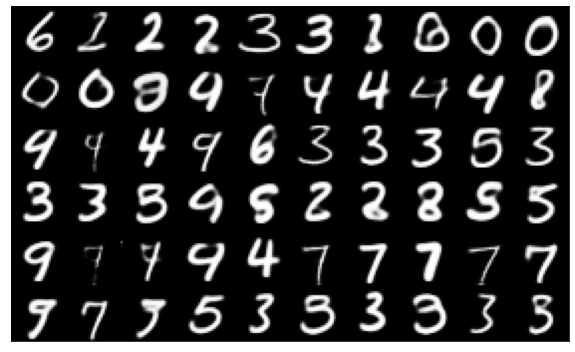

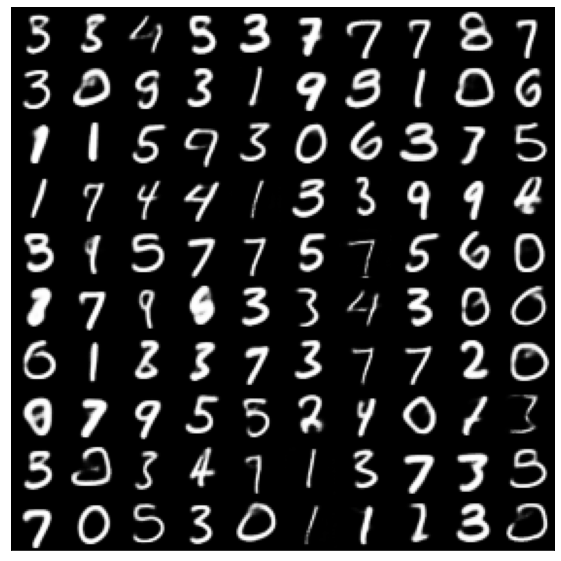

In [10]:
print('\nZ from LD')

inf_iter = 60
inf_rate = 0.01
eta = 0.2

make_gallery2(encoder, decoder, 'LD', inf_iter, inf_rate, eta)


Z from Residual sampling
original images


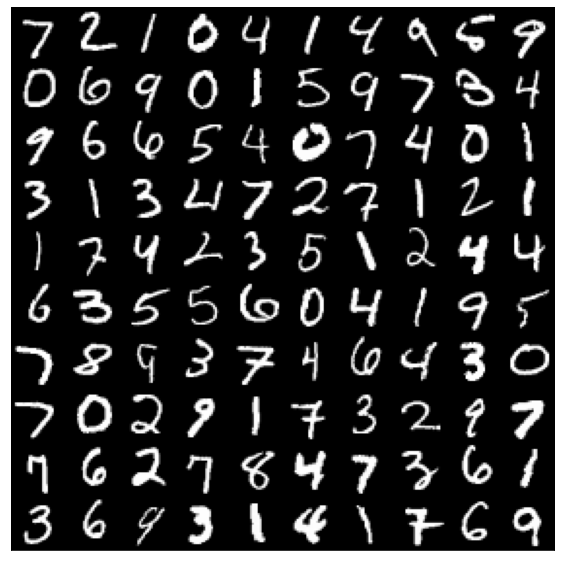

(100, 28, 28, 1)


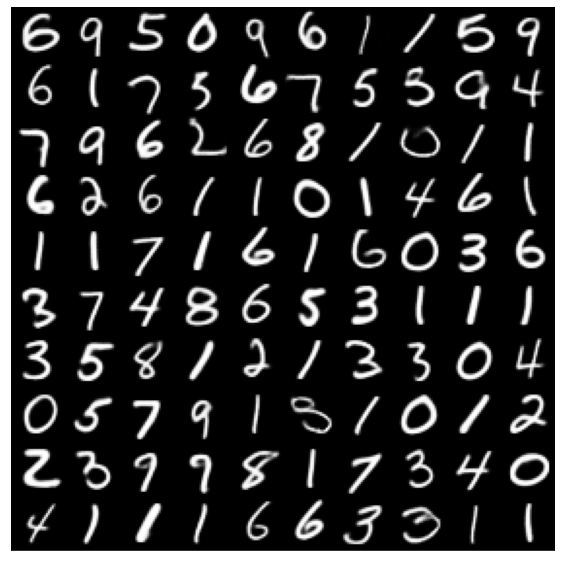

In [20]:
print('\nZ from Residual sampling')

make_gallery2(encoder, decoder, 'residual', inf_iter, inf_rate, eta)


Z from Residual sampling
original images


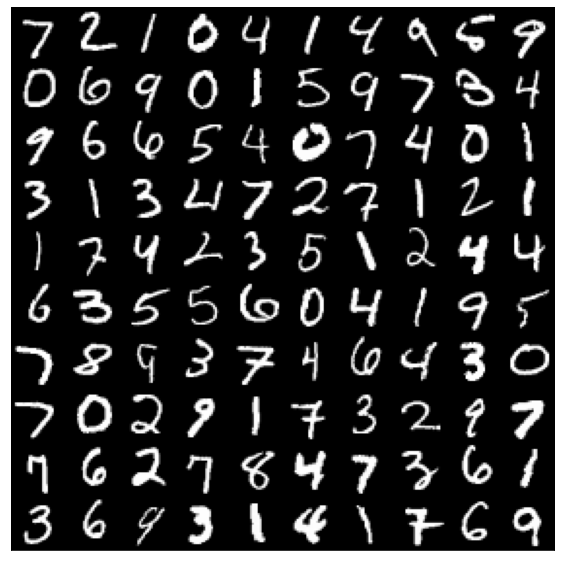

(100, 28, 28, 1)


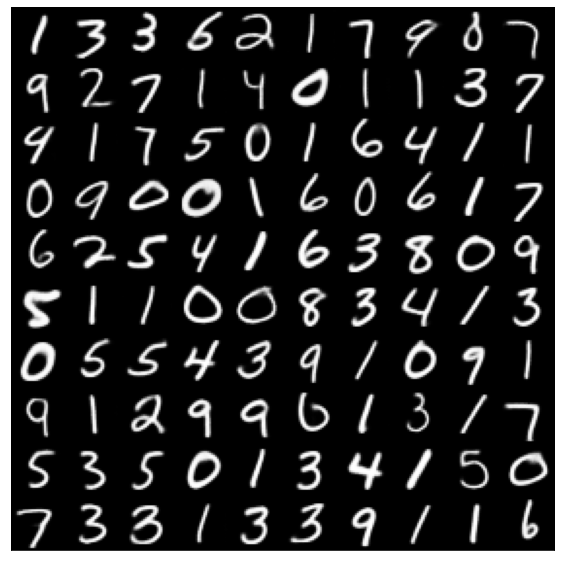

In [22]:
print('\nZ from Residual sampling')

make_gallery2(encoder, decoder, 'residual', inf_iter, inf_rate, eta)